In [1]:
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 8.5 MB/s 


In [42]:
import pandas as pd
from soynlp.noun import LRNounExtractor_v2
from soynlp.tokenizer import LTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LIFLOW/data/all_df_with_tokens_according_to_topic.csv')
len(df)

13091

In [5]:
sentences = list(df['sentence'])
noun_extractor = LRNounExtractor_v2(verbose=True)
nouns = noun_extractor.train_extract(sentences)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 195581 from 13091 sents. mem=0.624 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=3049355, mem=1.028 Gb
[Noun Extractor] batch prediction was completed for 47064 words
[Noun Extractor] checked compounds. discovered 22683 compounds
[Noun Extractor] postprocessing detaching_features : 34701 -> 27886
[Noun Extractor] postprocessing ignore_features : 27886 -> 27673
[Noun Extractor] postprocessing ignore_NJ : 27673 -> 26912
[Noun Extractor] 26912 nouns (22683 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.154 Gb                    
[Noun Extractor] 57.10 % eojeols are covered


In [6]:
noun_score = dict([])
for w, s in nouns.items() :
  noun_score[w] = s.score

In [28]:
tokenizer = LTokenizer(scores = noun_score)
tokens = [tokenizer.tokenize(s) for s in sentences]

In [29]:
# 한글이외 제거
for i in range(len(tokens)) :
  for j in range(len(tokens[i])) :
    tokens[i][j] = re.sub('[^ㄱ-힣]', '', tokens[i][j])

In [30]:
# 한글자 제거
tmp_tokens = []
for i in range(len(tokens)) :
  tmp = []
  for j in range(len(tokens[i])) :
    if len(tokens[i][j]) != 1 and tokens[i][j] != '' :
      tmp.append(tokens[i][j])
  tmp_tokens.append(tmp)
tokens = tmp_tokens[:]

In [31]:
voca = dict([])
for i in range(len(tokens)) :
  for j in range(len(tokens[i])) :
    if tokens[i][j] not in voca :
      voca[tokens[i][j]] = 1
    else :
      voca[tokens[i][j]] += 1

In [32]:
stop_words = [s[0] for s in sorted(voca.items(), key = lambda x : x[1], reverse = True)]
stop_words = stop_words[:100] # 100개만 사용

In [34]:
# stop_words 제거
X_data = []
for i in range(len(tokens)) :
  x_data = []
  for j in range(len(tokens[i])) :
    if tokens[i][j] not in stop_words :
      x_data.append(tokens[i][j])
  X_data.append(x_data)

In [35]:
y_data = list(df['convrsThema'])

In [36]:
print(X_data[0])
print(y_data[0])

['한끼', '제대', '한끼', '먹을', '있다고', '하면서', '감사', '감사', '하면서', '노후', '보내야', '되지', '않을까', '싶네', '제가', '가장', '연예', '인은', '별에서', '그대', '전지현', '이고', '잔디씨', '연예', '인은', '누구', '에요', '가장', '프로그램', '경우', '아는', '형님', '해피', '투게더', '에능예능', '프로그램', '프로그램', '하나요', '유튜', '브를', '하나요', '가끔', '가다', '유튜', '브를', '통해', '뮤직비디오', '보긴', '해요', '장르', '해요', '뮤직비디오', '경우', '유튜', '브에서', '그럼', '혹시', '티비', '프로그램', '은요', '예능', '프로그램', '중에서', '프로', '혹시', '있나요', '넷플릭스', '하는군요', '저도', '넷플릭스', '가끔', '가다', '보긴', '해요', '가장', '최근', '봤던', '넷플릭스', '드라마', '아니면', '중에서', '기억', '혹시', '있을까', '넷플릭스', '주로', '유튜', '브를', '보는군요', '나같은', '경우', '최근', '봤던', '중에서', '기억', '있어요', '에스맨엑스맨', '새로', '나온', '시리즈', '보고서', '감명', '깊고', '재밌게', '봤어요', '혹시', '중에서', '기억', '남는', '혹시', '있나요', '프로', '혹시', '음악', '장르', '혹시', '있을', '있을까', '내용', '따라', '다른가요', '내용', '야죠', '따라', '음악', '약간', '달라지네요', '경우', '발라드', '가끔', '가다', '연예', '인도', '해요', '그룹', '들도', '가끔', '가다', '보긴', '해요', '점도', '둘은', '약간', '차이', '있네요', '바다씨', '예능', '프로그램', '발전', '방향', '있나요', '되면은', '예능', '발전', '

In [37]:
# convrsThema 수가 15 이하인 데이터 지우기
y_count = dict([])
for i in range(len(y_data)) :
  if y_data[i] not in y_count :
    y_count[y_data[i]] = 1
  else :
    y_count[y_data[i]] += 1

In [38]:
y_deleted = [l if y_count[l] < 15 else 'used' for l in y_count]

In [39]:
X_tmp = []
y_tmp = []
for i in range(len(y_data)) :
  if y_data[i] not in y_deleted :
    X_tmp.append(X_data[i])
    y_tmp.append(y_data[i])
X_data = X_tmp[:]
y_data = y_tmp[:]
print(len(X_data))
print(len(y_data))

12644
12644


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49569 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_

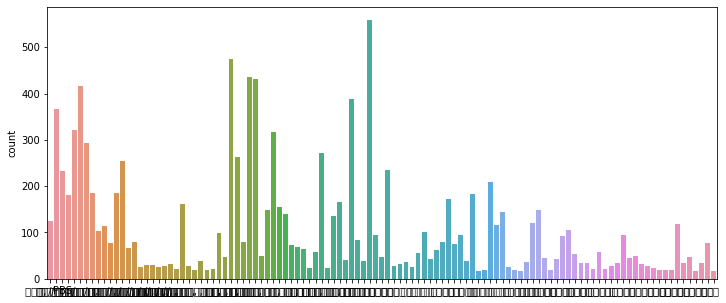

In [40]:
# label 분포
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_data)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 777)

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_to_index = tokenizer.word_index
print(word_to_index)

{'가고': 1, '차를': 2, '처음': 3, '음식': 4, '여행': 5, '해도': 6, '했어': 7, '경우': 8, '같아요': 9, '운전': 10, '전에': 11, '하면서': 12, '다음': 13, '있으면': 14, '하잖아': 15, '라고': 16, '것이': 17, '항상': 18, '갔다': 19, '아직': 20, '하나': 21, '없는': 22, '해요': 23, '되면': 24, '갖고': 25, '저는': 26, '거는': 27, '나라': 28, '집에': 29, '싶어': 30, '에도': 31, '거기서': 32, '없어': 33, '제일': 34, '되는데': 35, '사실': 36, '다시': 37, '별로': 38, '책을': 39, '문제': 40, '이야기': 41, '언니': 42, '타고': 43, '있지': 44, '아니면': 45, '하다': 46, '친구': 47, '부분': 48, '수도': 49, '일본': 50, '요새': 51, '당신': 52, '보다': 53, '여러': 54, '인데': 55, '부터': 56, '이야': 57, '있으니까': 58, '이번에': 59, '걱정': 60, '필요': 61, '무슨': 62, '많은': 63, '이상': 64, '아침': 65, '제가': 66, '거의': 67, '아니고': 68, '차가': 69, '좋을': 70, '대해서': 71, '보는': 72, '들어': 73, '아들': 74, '먹으면': 75, '있을': 76, '나중': 77, '앞으로': 78, '사고': 79, '열심히': 80, '오늘': 81, '아주': 82, '저기': 83, '같은데': 84, '같고': 85, '얼마나': 86, '얼마': 87, '이랑': 88, '있어서': 89, '시간이': 90, '시작': 91, '와서': 92, '사는': 93, '인가': 94, '그니까': 95, '물론': 96, '않고': 97, '없고': 98, '한다고': 

In [46]:
index_to_word = dict([])
for word, idx in word_to_index.items() :
  index_to_word[idx] = word
print(index_to_word)

{1: '가고', 2: '차를', 3: '처음', 4: '음식', 5: '여행', 6: '해도', 7: '했어', 8: '경우', 9: '같아요', 10: '운전', 11: '전에', 12: '하면서', 13: '다음', 14: '있으면', 15: '하잖아', 16: '라고', 17: '것이', 18: '항상', 19: '갔다', 20: '아직', 21: '하나', 22: '없는', 23: '해요', 24: '되면', 25: '갖고', 26: '저는', 27: '거는', 28: '나라', 29: '집에', 30: '싶어', 31: '에도', 32: '거기서', 33: '없어', 34: '제일', 35: '되는데', 36: '사실', 37: '다시', 38: '별로', 39: '책을', 40: '문제', 41: '이야기', 42: '언니', 43: '타고', 44: '있지', 45: '아니면', 46: '하다', 47: '친구', 48: '부분', 49: '수도', 50: '일본', 51: '요새', 52: '당신', 53: '보다', 54: '여러', 55: '인데', 56: '부터', 57: '이야', 58: '있으니까', 59: '이번에', 60: '걱정', 61: '필요', 62: '무슨', 63: '많은', 64: '이상', 65: '아침', 66: '제가', 67: '거의', 68: '아니고', 69: '차가', 70: '좋을', 71: '대해서', 72: '보는', 73: '들어', 74: '아들', 75: '먹으면', 76: '있을', 77: '나중', 78: '앞으로', 79: '사고', 80: '열심히', 81: '오늘', 82: '아주', 83: '저기', 84: '같은데', 85: '같고', 86: '얼마나', 87: '얼마', 88: '이랑', 89: '있어서', 90: '시간이', 91: '시작', 92: '와서', 93: '사는', 94: '인가', 95: '그니까', 96: '물론', 97: '않고', 98: '없고', 99: '한다

In [47]:
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[1381, 8416, 827, 788, 53], [87, 11, 249, 1234, 1967, 35063, 186, 4131, 42444, 4131, 1180, 802, 660, 441, 14556, 3476, 2019, 845, 17, 12874, 29524, 3147, 271, 233, 277, 1035, 845, 2569, 5774, 2039, 42445, 42446, 35064, 1708, 13672, 128, 6682, 1015, 6029, 12221, 1917, 638, 1686, 11029, 1256, 4471, 205, 185, 24, 3742, 30, 3742, 30, 29525, 5775, 908, 249, 474, 698, 11, 249, 4673, 667, 3742, 667, 99, 566, 4770, 1421, 249, 2005, 1802, 334, 1979, 1717, 6859, 1990, 45, 523, 15607, 1187, 84, 2005, 1802, 410, 706, 6683, 13673, 1979, 582, 13673, 88, 29526, 415, 1245, 2094, 1022, 6182, 3793, 40, 40, 363, 798, 1728, 1033, 1286, 1968, 245, 1331, 1048, 11, 87, 11, 1331, 1048, 11, 11603, 789, 1862, 185, 3363, 1802, 958, 914, 970, 383, 901, 2932, 188, 1112, 371, 4074, 185, 3742, 1528, 3848, 958, 42447, 30, 4600, 1803, 2665, 1803, 9321, 29527, 2333, 1275, 1587, 3954, 16828, 474, 7217, 8700, 347, 12875, 258, 62, 909, 11030, 2437, 909, 84, 119, 139, 660, 654, 84, 1124, 35065, 336, 9321, 12876, 139, 65, 

In [48]:
target_to_idx = dict([])
count = 0
for i in set(y_train) :
  target_to_idx[i] = count
  count += 1
print(target_to_idx)

{nan: 0, '시댁살이': 1, '자녀교육': 2, '운동선수': 3, '건강/교육': 4, '일': 5, '요리': 6, '투병': 7, '일상생활': 8, '자동차': 9, '가족': 10, ' 방송/연예 ': 11, '여행계획': 12, '운전면허': 13, '축구선수': 14, '노후': 15, '가족건강': 16, '해외여행': 17, '남편': 18, '양육/교육': 19, ' 국가/지역 ': 20, ' 연애/결혼 ': 21, '수영': 22, '재태크': 23, '휴일': 24, '자녀 결혼': 25, '자녀직장': 26, '문학': 27, '자녀 교육': 28, '시사/재테크': 29, ' 경제/재태크 ': 30, '돈': 31, '소비형태': 32, '등산': 33, '정신건강': 34, '축구': 35, '지인': 36, '일화': 37, '음식': 38, '연예인': 39, '친구': 40, '만화': 41, ' 스포츠/레저 ': 42, '스포츠': 43, '날씨/일상': 44, ' 여행, 지인, 집, 축구, 음식점, 자녀 등 ': 45, '드라마': 46, '운전': 47, '여행/자녀 ': 48, '부모님': 49, '캠핑': 50, '자연/여행': 51, '책': 52, '벌초': 53, '연애': 54, '결혼': 55, '가정': 56, '취업': 57, '게임': 58, ' 휴일 ': 59, '집값': 60, '건강': 61, '넷플릭스': 62, '골프': 63, '여행/콘서트': 64, '결혼생활': 65, '육아': 66, '영화': 67, '방송': 68, '노후준비': 69, '운동': 70, '자녀결혼': 71, '부동산': 72, '재테크': 73, ' 먹거리 ': 74, '독서': 75, ' 야구, 축구, 지하철역, 집값, 정치, 기차 등 ': 76, '보험': 77, ' 자연/휴양지 ': 78, '집': 79, '경제': 80, '여행': 81, ' 자동차 ': 82, '다이어트': 83, '술': 84, 'P

In [49]:
idx_to_target = dict([])
for t, idx in target_to_idx.items() :
  idx_to_target[idx] = t
print(idx_to_target)

{0: nan, 1: '시댁살이', 2: '자녀교육', 3: '운동선수', 4: '건강/교육', 5: '일', 6: '요리', 7: '투병', 8: '일상생활', 9: '자동차', 10: '가족', 11: ' 방송/연예 ', 12: '여행계획', 13: '운전면허', 14: '축구선수', 15: '노후', 16: '가족건강', 17: '해외여행', 18: '남편', 19: '양육/교육', 20: ' 국가/지역 ', 21: ' 연애/결혼 ', 22: '수영', 23: '재태크', 24: '휴일', 25: '자녀 결혼', 26: '자녀직장', 27: '문학', 28: '자녀 교육', 29: '시사/재테크', 30: ' 경제/재태크 ', 31: '돈', 32: '소비형태', 33: '등산', 34: '정신건강', 35: '축구', 36: '지인', 37: '일화', 38: '음식', 39: '연예인', 40: '친구', 41: '만화', 42: ' 스포츠/레저 ', 43: '스포츠', 44: '날씨/일상', 45: ' 여행, 지인, 집, 축구, 음식점, 자녀 등 ', 46: '드라마', 47: '운전', 48: '여행/자녀 ', 49: '부모님', 50: '캠핑', 51: '자연/여행', 52: '책', 53: '벌초', 54: '연애', 55: '결혼', 56: '가정', 57: '취업', 58: '게임', 59: ' 휴일 ', 60: '집값', 61: '건강', 62: '넷플릭스', 63: '골프', 64: '여행/콘서트', 65: '결혼생활', 66: '육아', 67: '영화', 68: '방송', 69: '노후준비', 70: '운동', 71: '자녀결혼', 72: '부동산', 73: '재테크', 74: ' 먹거리 ', 75: '독서', 76: ' 야구, 축구, 지하철역, 집값, 정치, 기차 등 ', 77: '보험', 78: ' 자연/휴양지 ', 79: '집', 80: '경제', 81: '여행', 82: ' 자동차 ', 83: '다이어트', 84: '술', 85

In [50]:
y_train_encoded = [target_to_idx[t] for t in y_train]
y_test_encoded = [target_to_idx[t] for t in y_test]
print(y_train_encoded)
print(y_test_encoded)

[0, 67, 73, 53, 10, 71, 29, 20, 63, 41, 104, 55, 72, 30, 77, 25, 2, 86, 85, 9, 24, 0, 71, 80, 70, 0, 104, 20, 37, 2, 32, 54, 85, 105, 0, 86, 78, 70, 37, 72, 17, 37, 15, 86, 103, 0, 95, 67, 61, 39, 105, 27, 21, 22, 86, 81, 23, 34, 30, 2, 9, 61, 61, 61, 70, 37, 34, 95, 82, 70, 0, 67, 39, 81, 37, 50, 21, 60, 37, 92, 17, 37, 61, 53, 81, 34, 30, 67, 81, 37, 56, 52, 95, 8, 0, 106, 8, 0, 37, 34, 55, 91, 17, 79, 30, 69, 74, 61, 91, 24, 24, 30, 75, 0, 61, 74, 80, 43, 103, 86, 8, 103, 33, 0, 78, 74, 63, 74, 11, 37, 30, 91, 43, 52, 90, 59, 8, 67, 74, 37, 0, 0, 0, 19, 67, 37, 67, 4, 27, 41, 12, 0, 80, 3, 31, 87, 82, 37, 27, 1, 74, 37, 75, 0, 107, 13, 47, 34, 53, 24, 61, 81, 27, 0, 9, 95, 23, 85, 72, 5, 95, 107, 91, 13, 85, 63, 91, 105, 61, 10, 11, 103, 55, 95, 9, 11, 37, 81, 81, 79, 52, 105, 33, 69, 86, 30, 81, 91, 61, 74, 2, 0, 80, 86, 9, 61, 42, 89, 0, 20, 47, 67, 98, 9, 77, 27, 38, 10, 29, 98, 0, 9, 70, 27, 86, 24, 59, 27, 9, 20, 47, 111, 0, 86, 81, 103, 83, 37, 38, 79, 30, 39, 101, 30, 95, 27,

X 최대 길이 :  5522
X 평균 길이 :  148.9192288680178


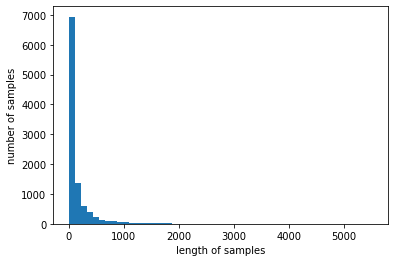

In [51]:
print('X 최대 길이 : ', max(len(w) for w in X_train_encoded))
print('X 평균 길이 : ', sum(map(len, X_train_encoded)) / len(X_train_encoded))

plt.hist([len(sample) for sample in X_train_encoded], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

X 최대 길이 :  3797
X 평균 길이 :  143.0375642546461


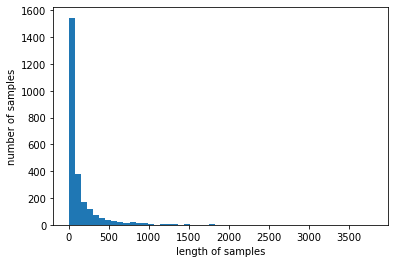

In [52]:
print('X 최대 길이 : ', max(len(w) for w in X_test_encoded))
print('X 평균 길이 : ', sum(map(len, X_test_encoded)) / len(X_test_encoded))
# 제대로 분류되는 최소 대화길이 확인하기
plt.hist([len(sample) for sample in X_test_encoded], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [57]:
max_len = 160
embedding_dim = 256
hidden_units = 256
X_train_pad = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_pad = pad_sequences(X_test_encoded, maxlen=max_len)

y_train_pad = to_categorical(y_train_encoded)
y_test_pad = to_categorical(y_test_encoded)

vocab_size = len(tokenizer.word_index)
num_classes = len(target_to_idx)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model' + str(max_len) + str(embedding_dim) + str(hidden_units) + '.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_pad, y_train_pad, batch_size=128, epochs=30, callbacks=[es, mc], validation_split=0.2)

Epoch 1/30
63/64 [============================>.] - ETA: 0s - loss: 4.2050 - acc: 0.0969
Epoch 1: val_acc improved from -inf to 0.14582, saving model to best_model160256256.h5
64/64 [==============================] - 5s 49ms/step - loss: 4.2032 - acc: 0.0970 - val_loss: 3.9247 - val_acc: 0.1458
Epoch 2/30
63/64 [============================>.] - ETA: 0s - loss: 3.6099 - acc: 0.1874
Epoch 2: val_acc improved from 0.14582 to 0.17746, saving model to best_model160256256.h5
64/64 [==============================] - 3s 40ms/step - loss: 3.6083 - acc: 0.1876 - val_loss: 3.7005 - val_acc: 0.1775
Epoch 3/30
63/64 [============================>.] - ETA: 0s - loss: 2.8492 - acc: 0.3438
Epoch 3: val_acc improved from 0.17746 to 0.39397, saving model to best_model160256256.h5
64/64 [==============================] - 3s 41ms/step - loss: 2.8468 - acc: 0.3445 - val_loss: 2.7009 - val_acc: 0.3940
Epoch 4/30
63/64 [============================>.] - ETA: 0s - loss: 1.5951 - acc: 0.6494
Epoch 4: val_acc 

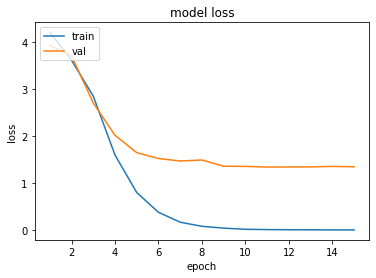

In [58]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
model = load_model('best_model160256256.h5')

In [64]:
model.predict(X_test_pad)

array([[5.9928546e-08, 6.0292993e-09, 3.9008377e-08, ..., 1.1120519e-09,
        7.4975475e-09, 3.0464513e-09],
       [2.2304323e-07, 2.7247598e-09, 2.2742448e-08, ..., 1.3867525e-10,
        2.4462727e-07, 4.2720143e-09],
       [3.5427504e-08, 1.6880996e-07, 1.2569746e-08, ..., 3.6130645e-09,
        1.7328863e-07, 3.1409326e-07],
       ...,
       [9.9783272e-01, 1.3855777e-08, 4.3235127e-06, ..., 1.7777322e-09,
        1.0584478e-06, 8.6564519e-08],
       [3.6818325e-05, 2.7494101e-08, 3.2211634e-07, ..., 9.7404340e-10,
        4.1467587e-07, 6.1941159e-09],
       [1.2804371e-03, 1.4384350e-08, 2.1622329e-05, ..., 4.8159905e-07,
        8.9088110e-07, 2.8179556e-06]], dtype=float32)

In [65]:
y_test_pad

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [79]:
wrong_ex_encoded = dict([])
X = list(X_test_pad)
prediction = list(model.predict(X_test_pad))
label = list(y_test_pad)
for i in range(len(X)) :
  pred = np.argmax(prediction[i])
  l = list(label[i]).index(max(list(label[i])))
  if pred != l and l not in wrong_ex_encoded :
    wrong_ex_encoded[l] = {pred : 1}
  elif pred != l and l in wrong_ex_encoded :
    if pred not in wrong_ex_encoded[l] :
      wrong_ex_encoded[l][pred] = 1
    else :
      wrong_ex_encoded[l][pred] += 1

In [80]:
wrong_ex_encoded

{0: {81: 2,
  61: 4,
  40: 2,
  103: 8,
  86: 6,
  70: 3,
  78: 2,
  21: 1,
  72: 1,
  82: 2,
  105: 6,
  4: 1,
  67: 1,
  39: 3,
  30: 5,
  15: 1,
  65: 1,
  37: 2,
  85: 2,
  20: 1,
  104: 1,
  101: 1,
  43: 1,
  59: 1,
  50: 1,
  17: 3,
  38: 1,
  44: 2,
  11: 1,
  24: 1,
  63: 1,
  74: 1,
  42: 1},
 75: {48: 1, 83: 1, 50: 1},
 68: {61: 1, 63: 1, 11: 1, 67: 1, 103: 1},
 9: {77: 1,
  81: 1,
  61: 2,
  37: 2,
  82: 6,
  59: 1,
  89: 1,
  13: 1,
  80: 1,
  47: 1,
  39: 1},
 40: {83: 1, 55: 1, 95: 1, 104: 1, 24: 1},
 30: {72: 1,
  11: 2,
  82: 1,
  0: 4,
  80: 1,
  79: 1,
  67: 1,
  103: 1,
  39: 1,
  34: 1,
  47: 1},
 39: {61: 1, 16: 1, 38: 1, 11: 1, 10: 1, 103: 1, 67: 1, 3: 1, 34: 1},
 43: {65: 1, 35: 1, 8: 1, 10: 1, 108: 1, 55: 3, 98: 1, 89: 1, 63: 1},
 20: {0: 2,
  78: 2,
  100: 1,
  8: 1,
  89: 1,
  81: 3,
  54: 1,
  59: 2,
  104: 2,
  67: 1,
  106: 1,
  61: 1,
  17: 1,
  12: 1,
  74: 1},
 83: {38: 1},
 34: {13: 2, 30: 2, 55: 1, 101: 1, 39: 1, 67: 1, 11: 1},
 29: {11: 1, 78: 1, 42:

In [81]:
wrong_ex_reverted = dict([])
for y, d in wrong_ex_encoded.items() :
  tmp = dict([])
  for w, c in d.items() :
    tmp[idx_to_target[w]] = c
  wrong_ex_reverted[idx_to_target[y]] = tmp

In [82]:
wrong_ex_reverted

{nan: {'여행': 2,
  '건강': 4,
  '친구': 2,
  ' 영화 ': 8,
  ' 건강/다이어트 ': 6,
  '운동': 3,
  ' 자연/휴양지 ': 2,
  ' 연애/결혼 ': 1,
  '부동산': 1,
  ' 자동차 ': 2,
  '먹거리': 6,
  '건강/교육': 1,
  '영화': 1,
  '연예인': 3,
  ' 경제/재태크 ': 5,
  '노후': 1,
  '결혼생활': 1,
  '일화': 2,
  'PBS': 2,
  ' 국가/지역 ': 1,
  '휴양지': 1,
  '직장': 1,
  '스포츠': 1,
  ' 휴일 ': 1,
  '캠핑': 1,
  '해외여행': 3,
  '음식': 1,
  '날씨/일상': 2,
  ' 방송/연예 ': 1,
  '휴일': 1,
  '골프': 1,
  ' 먹거리 ': 1,
  ' 스포츠/레저 ': 1},
 '독서': {'여행/자녀 ': 1, '다이어트': 1, '캠핑': 1},
 '방송': {'건강': 1, '골프': 1, ' 방송/연예 ': 1, '영화': 1, ' 영화 ': 1},
 '자동차': {'보험': 1,
  '여행': 1,
  '건강': 2,
  '일화': 2,
  ' 자동차 ': 6,
  ' 휴일 ': 1,
  '환경': 1,
  '운전면허': 1,
  '경제': 1,
  '운전': 1,
  '연예인': 1},
 '친구': {'다이어트': 1, '결혼': 1, '자녀': 1, '휴양지': 1, '휴일': 1},
 ' 경제/재태크 ': {'부동산': 1,
  ' 방송/연예 ': 2,
  ' 자동차 ': 1,
  nan: 4,
  '경제': 1,
  '집': 1,
  '영화': 1,
  ' 영화 ': 1,
  '연예인': 1,
  '정신건강': 1,
  '운전': 1},
 '연예인': {'건강': 1,
  '가족건강': 1,
  '음식': 1,
  ' 방송/연예 ': 1,
  '가족': 1,
  ' 영화 ': 1,
  '영화': 1,
  '운동선수': 1,
  '정신건강': 1},
 '